# 1. Overview

# 2. Forecasting

## 2.1 Import Libraries

In [1]:
# pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global variables

In [3]:
input_data = 'data/weekly_data.csv'

## 2.3 Functions

In [4]:
# Feature engineering for time series
def create_features(df):
    """
    Create time-based features for time series data.
    
    Input:
    - df: DataFrame with a datetime index and a single column for the target variable.

    Output:
    - df: DataFrame with added columns for year, month, week of the year, quarter, and cuatrimestre.

    Logic:
    - Extracts the 'year', 'month', 'week_of_year', 'quarter', and 'cuatrimestre' 
      from the datetime index to create additional time-based features.
    """
    df = df.copy()  # Create a copy of the DataFrame to avoid the warning
    df['year'] = df.index.year            # Extract year from the date
    df['month'] = df.index.month          # Extract month from the date
    df['week_of_year'] = df.index.isocalendar().week  # Extract week of the year from the date
    df['quarter'] = df.index.quarter      # Extract quarter from the date
    df['cuatrimestre'] = ((df.index.month - 1) // 4) + 1  # Calculate cuatrimestre (four-month period)
    return df

## 2.4 Code

In [5]:
weekly_data = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data['Date'] = pd.to_datetime(weekly_data['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data = weekly_data.asfreq('W')

weekly_data.head()

,Close
Date,
2013-01-13,56.677265
2013-01-20,57.336109
2013-01-27,62.250618
2013-02-03,67.013779
2013-02-10,67.654816


### 2.4.1 Train test split

In [6]:
train_data = weekly_data[:-12]
train_data

,Close
Date,
2013-01-13,56.677265
2013-01-20,57.336109
2013-01-27,62.250618
2013-02-03,67.013779
2013-02-10,67.654816
...,...
2024-07-07,1069.428589
2024-07-14,1075.397461
2024-07-21,930.336243


In [7]:
test_data = weekly_data[-12:]
test_data

,Close
Date,
2024-08-11,843.010010
2024-08-18,879.580017
2024-08-25,926.179993
2024-09-01,888.130005
2024-09-08,811.479980
2024-09-15,800.140015
2024-09-22,803.039978
2024-09-29,818.179993
2024-10-06,832.409973


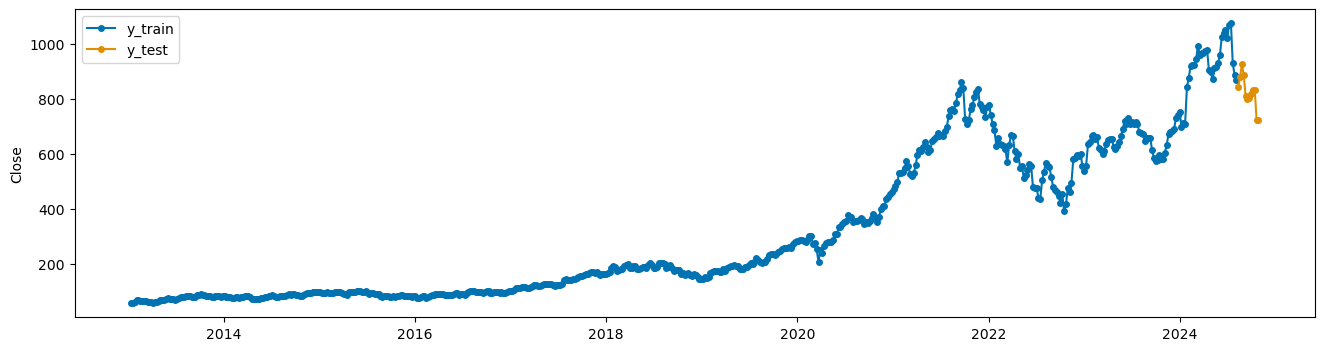

In [8]:
plot_series(train_data, test_data, labels=["y_train", "y_test"]);

### 2.4.2 Naive forecaster

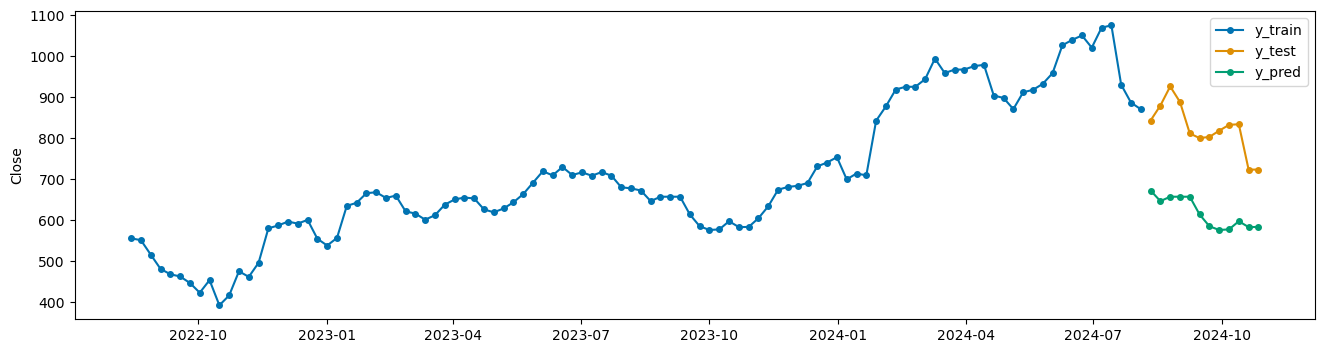

In [9]:
# Initialize the Naive Forecaster (strategy = 'last' means it will use the last value)
naive_forecaster = NaiveForecaster(strategy="last", sp=52)

# Fit the model to the training data
naive_forecaster.fit(train_data)

# Make predictions on the test set
y_pred_naive = naive_forecaster.predict(fh=[i+1 for i in range(len(test_data))])

# Plot the training, test data, and predictions
plot_series(train_data[500:], test_data, y_pred_naive, labels=["y_train", "y_test", "y_pred"]);


Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [10]:
mape_naive = mean_absolute_percentage_error(test_data, y_pred_naive) * 100
mape_naive

24.891185667900636

In [11]:
rmse_naive = root_mean_squared_error(test_data, y_pred_naive)
rmse_naive

211.05090975803688

### 2.4.3 ETS 

Initialize the ETS model with additive trend and seasonality 'seasonal_periods' should be set based on the periodicity of the data

In [12]:
ets_model_add = ExponentialSmoothing(
    train_data, 
    trend='add',          # Can also use 'mul' for multiplicative trend
    seasonal='add',       # Can also use 'mul' for multiplicative seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

Fit the model to the training data

In [13]:
fitted_model_add = ets_model_add.fit()

Generate predictions for the test set

In [14]:
y_pred_ets_add = fitted_model_add.forecast(len(test_data))

Plot the training, test data, and predictions

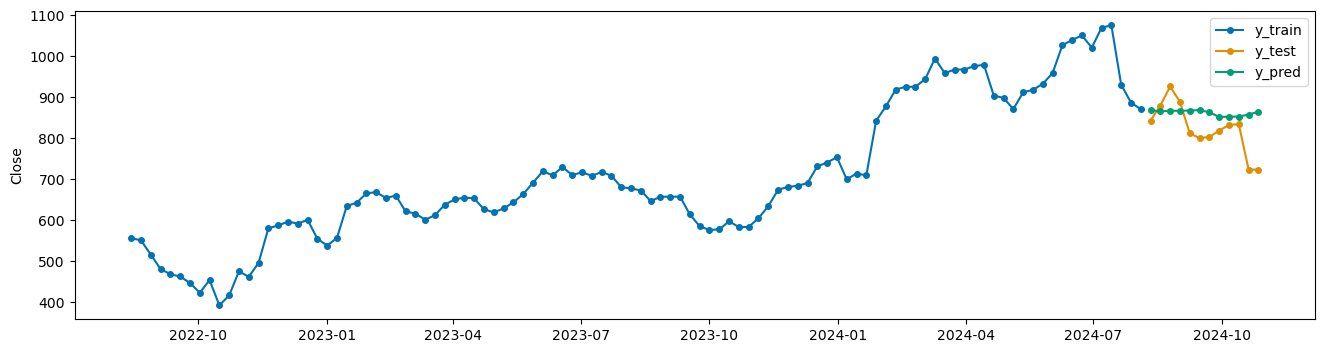

In [15]:
plot_series(train_data[500:], test_data, y_pred_ets_add, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [16]:
mape_ets_add = mean_absolute_percentage_error(test_data, y_pred_ets_add) * 100
mape_ets_add

6.933087168683802

In [17]:
rmse_ets_add = root_mean_squared_error(test_data, y_pred_ets_add)
rmse_ets_add

68.3794667654434

We are going to retry the ETS model but now we are going to modify the trend and seasonality to be multiplicative

In [18]:
ets_model_mul = ExponentialSmoothing(
    train_data, 
    trend='mul',          # Can also use 'add' for additive trend
    seasonal='mul',       # Can also use 'add' for additive seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

Fit the model to the training data

In [19]:
fitted_model_mul = ets_model_mul.fit()

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Generate predictions for the test set

In [20]:
y_pred_ets_mul = fitted_model_mul.forecast(len(test_data))

Plot the training, test data, and predictions

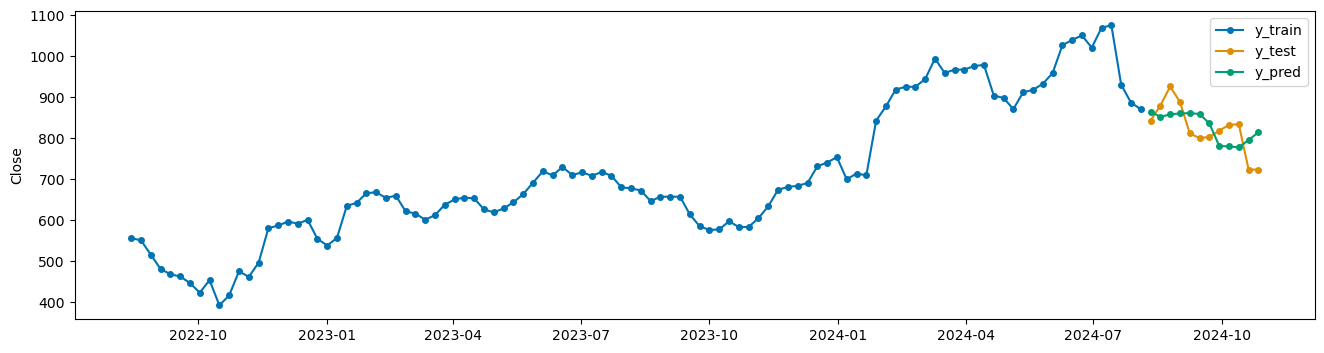

In [21]:
plot_series(train_data[500:], test_data, y_pred_ets_mul, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [22]:
mape_ets_mul = mean_absolute_percentage_error(test_data, y_pred_ets_mul) * 100
mape_ets_mul

6.160616399412125

In [23]:
rmse_ets_mul = root_mean_squared_error(test_data, y_pred_ets_mul)
rmse_ets_mul

53.602260512412364

### 2.4.4 SARIMA

Initialize the SARIMA Model

In [24]:
sarima_model = SARIMAX(
    train_data,                # Training data
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

In [25]:
# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

In [26]:
# Generate predictions for the test set
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data))

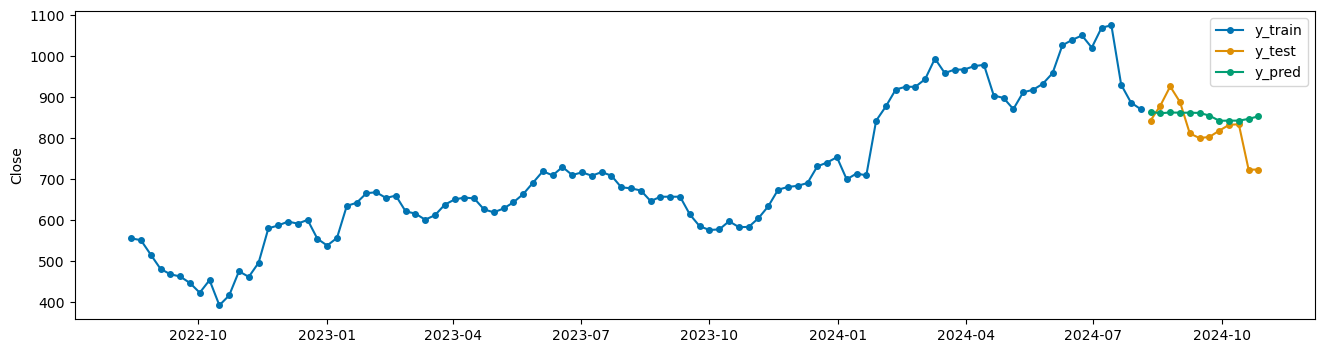

In [27]:
# Plot the training, test data, and predictions
plot_series(train_data[500:], test_data, y_pred_sarima, labels=["y_train", "y_test", "y_pred"]);

In [28]:
# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data, y_pred_sarima) * 100
mape_sarima

6.264765593794959

In [29]:
# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data, y_pred_sarima)
rmse_sarima

62.94881207164143

### 2.4.5 Prophet

Initialize the Prophet model

In [30]:
prophet_model = Prophet()

Fit the model to the data

First we need to modify the column names as is required by prophet

In [31]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
train_data_prophet

,ds,y
0,2013-01-13,56.677265
1,2013-01-20,57.336109
2,2013-01-27,62.250618
3,2013-02-03,67.013779
4,2013-02-10,67.654816
...,...,...
599,2024-07-07,1069.428589
600,2024-07-14,1075.397461
601,2024-07-21,930.336243
602,2024-07-28,886.747009


In [32]:
prophet_model.fit(train_data_prophet)

19:24:20 - cmdstanpy - INFO - Chain [1] start processing
19:24:21 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# Define the forecast horizon (e.g., 8 periods into the future)
future = prophet_model.make_future_dataframe(periods=12, freq='W')

# Generate predictions
forecast = prophet_model.predict(future)

Plot forecast components (trend, weekly, yearly components)

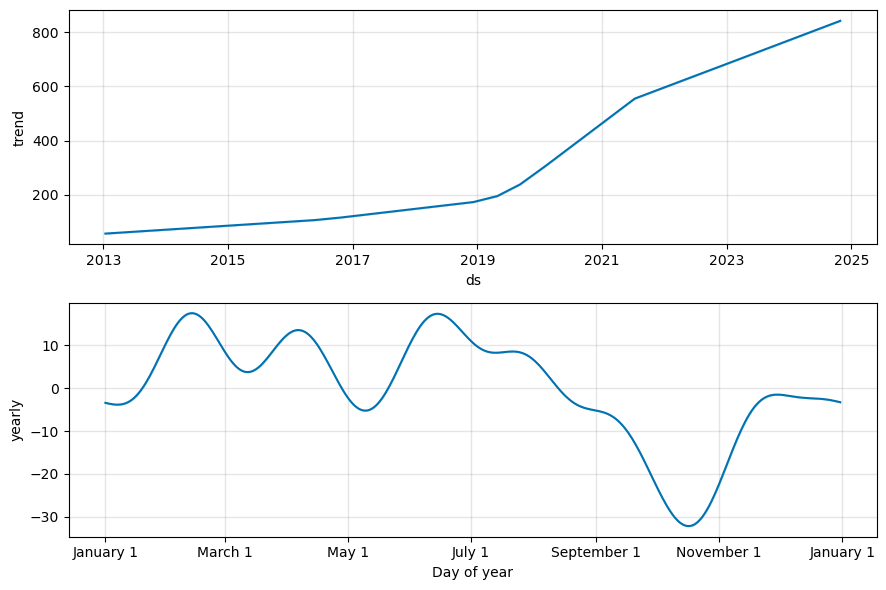

In [34]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

In [35]:
# Going back to the train_data format
forecast = forecast[['ds','yhat']].set_index('ds').rename(columns={'yhat':'Close'})[-12:]

forecast

,Close
ds,
2024-08-11,824.933510
2024-08-18,823.027953
2024-08-25,822.690817
2024-09-01,823.564322
2024-09-08,824.119265
2024-09-15,822.850726
2024-09-22,819.299525
2024-09-29,814.301971
2024-10-06,809.607682


Plot the forecast results

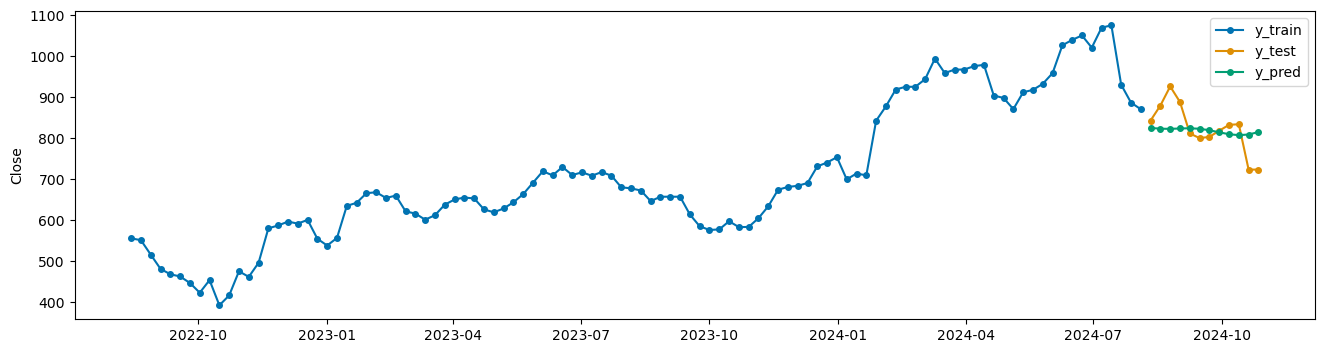

In [36]:
plot_series(train_data[500:], test_data, forecast, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [37]:
mape_prophet = mean_absolute_percentage_error(test_data, forecast) * 100
mape_prophet

5.36336877115334

In [38]:
rmse_prophet = root_mean_squared_error(test_data, forecast)
rmse_prophet

55.013338778410336

### 2.4.6 XGboost

In [39]:
train_data = create_features(train_data)
test_data = create_features(test_data)

In [40]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train = train_data.drop('Close', axis=1)
y_train = train_data['Close']
X_test = test_data.drop('Close', axis=1)
y_test = test_data['Close']

In [41]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [42]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
# Generate predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close'])

In [44]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
rmse_xgb

70.56541789124057

In [45]:
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)*100
mape_xgb

7.290917495795725

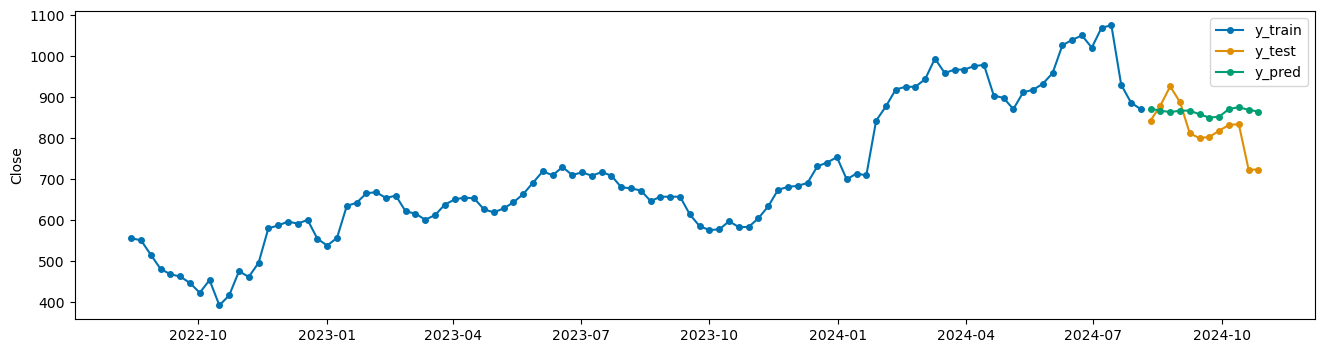

In [46]:
# Plot actual vs. predicted values
plot_series(y_train[500:], y_test, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

### 2.4.7 Random Forest

In [47]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [48]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [49]:
# Generate predictions
y_pred_rf = rf_model.predict(X_test)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

In [50]:
# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
rmse_rf

95.4295610734148

In [51]:
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)*100
mape_rf

10.27227195307005

In [52]:
train_data

,Close,year,month,week_of_year,quarter,cuatrimestre
2013-01-13,56.677265,2013,1,2,1,1
2013-01-20,57.336109,2013,1,3,1,1
2013-01-27,62.250618,2013,1,4,1,1
2013-02-03,67.013779,2013,2,5,1,1
2013-02-10,67.654816,2013,2,6,1,1
...,...,...,...,...,...,...
2024-07-07,1069.428589,2024,7,27,3,2
2024-07-14,1075.397461,2024,7,28,3,2
2024-07-21,930.336243,2024,7,29,3,2
2024-07-28,886.747009,2024,7,30,3,2


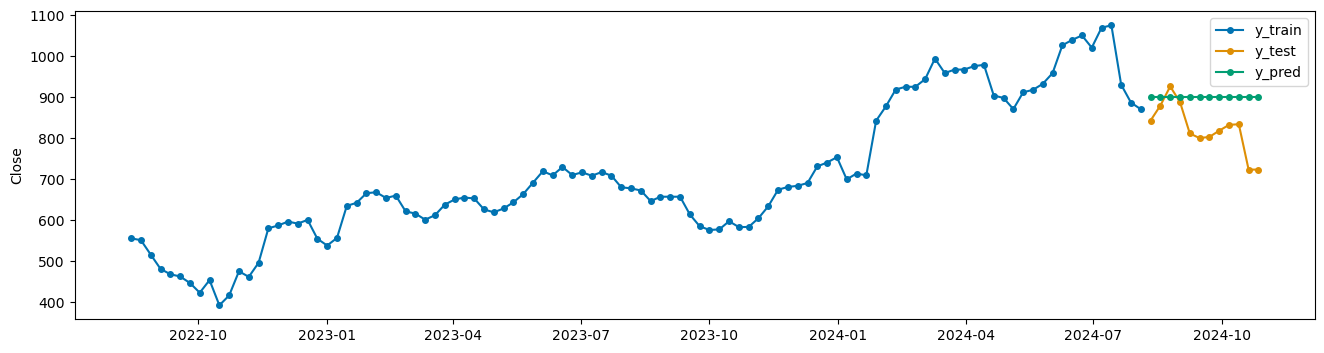

In [53]:
# Plot actual vs. predicted values
plot_series(y_train[500:], y_test, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

### 2.4.8 RMSE and MAPE comparison

In [55]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["Naive", "ETS (Additive)", "ETS (Multiplicative)", "SARIMA", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_naive,
        rmse_ets_add,
        rmse_ets_mul,
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_naive,
        mape_ets_add,
        mape_ets_mul,
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [56]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,Naive,211.050910,24.891186
1,ETS (Additive),68.379467,6.933087
2,ETS (Multiplicative),53.602261,6.160616
3,SARIMA,62.948812,6.264766
4,Prophet,55.013339,5.363369
5,XGBoost,70.565418,7.290917
6,Random Forest,95.429561,10.272272


Our best model is Prophet as it has the lowest RMSE and MAPE